<a href="https://colab.research.google.com/github/conglapgit45/Multilayer_Perceptrons/blob/main/MLP_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto_MPG

In [1]:
! gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 26.1MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# fix random seed

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [4]:
# set computing device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# read data

dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

In [6]:
# split data to features and label

X = dataset.drop(columns = 'MPG').values
y = dataset['MPG'].values

In [7]:
# split data to train, test and val

val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = val_size ,
    random_state = random_state ,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle
)

In [8]:
# standardize input features

normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

In [9]:
# build dataloader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size ,
    shuffle = True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [30]:
# build MLP network

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Tanh()
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [31]:
# initialize model variances

input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

In [32]:
# declare loss function and optimizer

lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [33]:
# define R2 function

def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [34]:
#  train model

epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer . step ()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f'\n EPOCH {epoch + 1}: \t Training loss: {train_loss:.3f} \t Validation loss: {val_loss:.3f}')


 EPOCH 1: 	 Training loss: 424.652 	 Validation loss: 181.264

 EPOCH 2: 	 Training loss: 185.595 	 Validation loss: 414.276

 EPOCH 3: 	 Training loss: 136.164 	 Validation loss: 21.991

 EPOCH 4: 	 Training loss: 63.342 	 Validation loss: 36.412

 EPOCH 5: 	 Training loss: 25.888 	 Validation loss: 39.948

 EPOCH 6: 	 Training loss: 20.180 	 Validation loss: 35.770

 EPOCH 7: 	 Training loss: 14.948 	 Validation loss: 5.811

 EPOCH 8: 	 Training loss: 9.732 	 Validation loss: 14.324

 EPOCH 9: 	 Training loss: 18.773 	 Validation loss: 6.808

 EPOCH 10: 	 Training loss: 13.099 	 Validation loss: 26.296

 EPOCH 11: 	 Training loss: 14.697 	 Validation loss: 6.361

 EPOCH 12: 	 Training loss: 16.093 	 Validation loss: 11.408

 EPOCH 13: 	 Training loss: 9.254 	 Validation loss: 12.717

 EPOCH 14: 	 Training loss: 7.909 	 Validation loss: 4.970

 EPOCH 15: 	 Training loss: 7.499 	 Validation loss: 8.514

 EPOCH 16: 	 Training loss: 9.185 	 Validation loss: 7.155

 EPOCH 17: 	 Training 

In [35]:
# evaluate model

model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'R2: {test_set_r2}')

Evaluation on test set:
R2: 0.8697317242622375


# NonLinear_data

In [36]:
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 19.9MB/s]


In [37]:
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
import torch
import torch .nn as nn
import torch .nn. functional as F
from torch . utils . data import Dataset , DataLoader

from sklearn . model_selection import train_test_split
from sklearn . preprocessing import StandardScaler

In [38]:
# fix random seed and set computing device

device = torch.device('cuda: 0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [39]:
# read data

data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle = True).item()
X, y = data['X'], data ['labels']
print(X.shape, y.shape)

(300, 2) (300,)


In [40]:
# split data to train, val, test

val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = val_size,
    random_state = random_state,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle
)

In [41]:
# standardize input features

normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

In [42]:
# build dataloader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size ,
    shuffle = True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [63]:
# build MLP network

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.tanh(x)
        x = self.linear2(x)
        x = F.tanh(x)
        out = self.output(x)
        return out.squeeze(1)

In [70]:
# initialize model variances

input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 512

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

In [71]:
# declare loss function and optimizer

lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [72]:
# define accuracy function

def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim = 1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [73]:
# train model

epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []

    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print (f'\n EPOCH {epoch + 1}: \t Training loss: {train_loss:.3f} \t Validation loss: {val_loss:.3f}')


 EPOCH 1: 	 Training loss: 0.855 	 Validation loss: 0.888

 EPOCH 2: 	 Training loss: 0.824 	 Validation loss: 0.898

 EPOCH 3: 	 Training loss: 0.762 	 Validation loss: 0.828

 EPOCH 4: 	 Training loss: 0.726 	 Validation loss: 0.828

 EPOCH 5: 	 Training loss: 0.715 	 Validation loss: 0.836

 EPOCH 6: 	 Training loss: 0.685 	 Validation loss: 0.785

 EPOCH 7: 	 Training loss: 0.677 	 Validation loss: 0.775

 EPOCH 8: 	 Training loss: 0.659 	 Validation loss: 0.741

 EPOCH 9: 	 Training loss: 0.643 	 Validation loss: 0.751

 EPOCH 10: 	 Training loss: 0.597 	 Validation loss: 0.677

 EPOCH 11: 	 Training loss: 0.571 	 Validation loss: 0.651

 EPOCH 12: 	 Training loss: 0.557 	 Validation loss: 0.558

 EPOCH 13: 	 Training loss: 0.490 	 Validation loss: 0.554

 EPOCH 14: 	 Training loss: 0.494 	 Validation loss: 0.549

 EPOCH 15: 	 Training loss: 0.454 	 Validation loss: 0.515

 EPOCH 16: 	 Training loss: 0.396 	 Validation loss: 0.456

 EPOCH 17: 	 Training loss: 0.443 	 Validation l

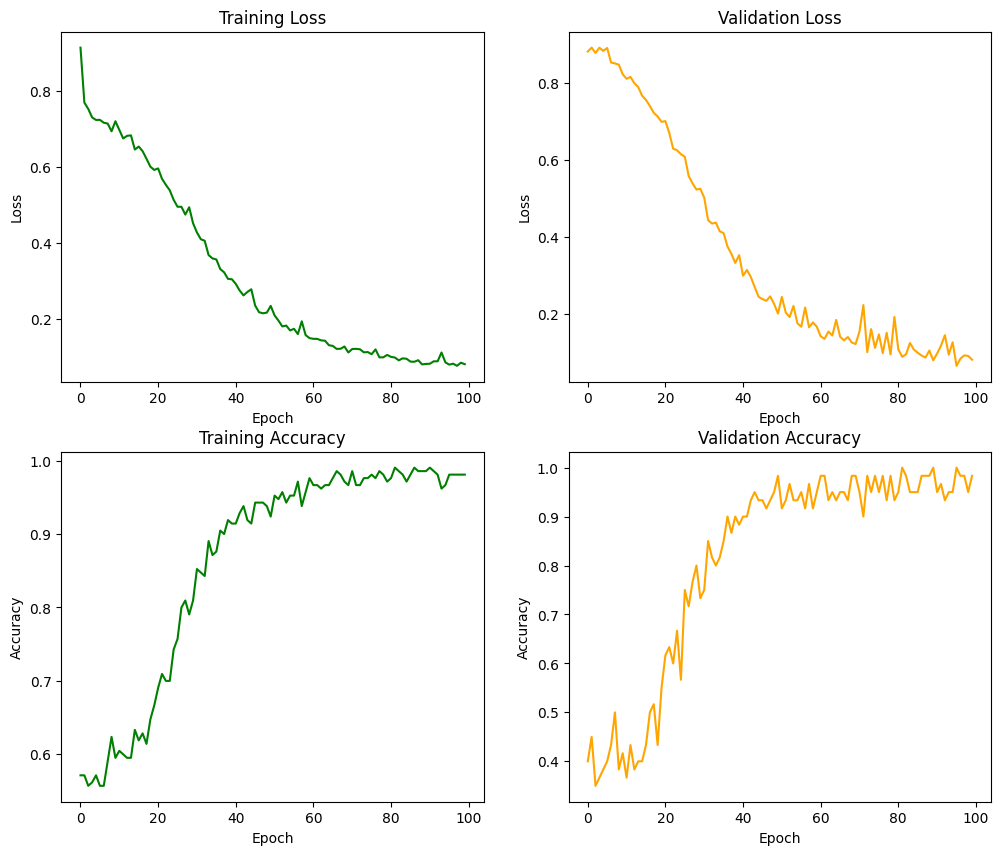

In [68]:
# visualize result

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color = 'green')
ax[0, 0].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color = 'orange')
ax[0, 1].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color = 'green')
ax[1, 0].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color = 'orange')
ax[1, 1].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [75]:
# evaluate model

test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9333333333333333


# FER-2013

In [77]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
!unzip -q './FER-2013.zip'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=8d4700f1-6afe-4cd7-82ae-f2ad2841bdfc
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 44.2MB/s]


In [78]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [79]:
# fix random seed and set computing device

device = torch.device('cuda: 0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [86]:
# read data

train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}


# Define img_height and img_width
img_height = 48
img_width = 48

In [87]:
# build dataLoader

class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split = 'train', train_ratio = 0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size = train_ratio,
                random_state = random_state,
                stratify = self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self . img_paths , self . img_labels = zip (* val_data )

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label


batch_size = 256

train_dataset = ImageDataset(train_dir, False, label2idx, split = 'train')

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)

val_dataset = ImageDataset(
    train_dir,
    True,
    label2idx,
    split = 'val'
)

val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False
)

test_dataset = ImageDataset(
    test_dir,
    True,
    label2idx,
    split = 'test'

)

test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False
)

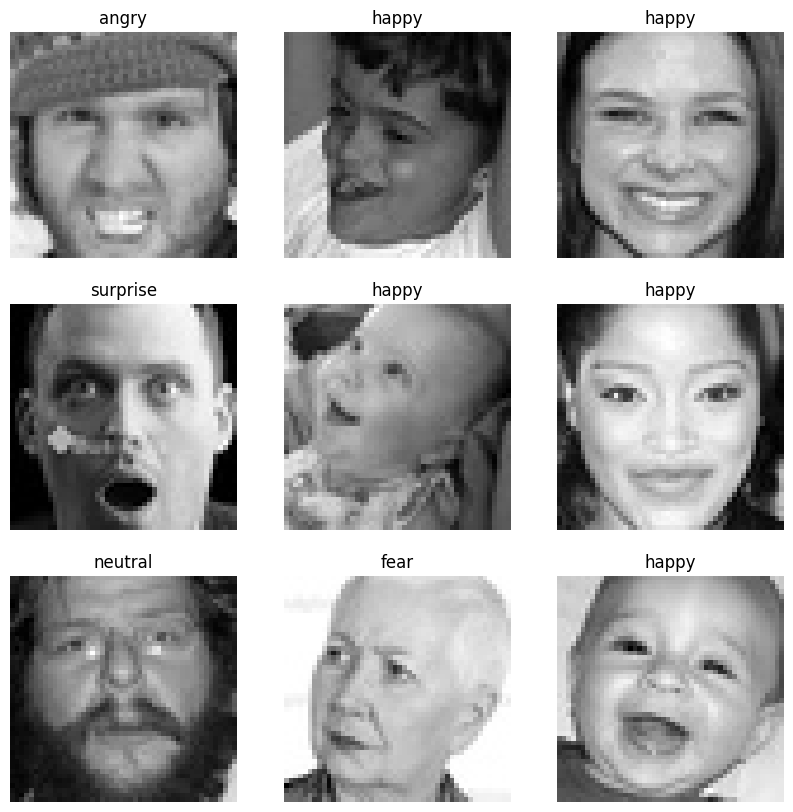

In [88]:
# visualize some samples

image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin = minv , vmax = maxv, cmap = "gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

In [97]:
# build MLP network

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims  *4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
        # self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
        self.output = nn.Linear(2 * hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        # x = self.linear3(x)
        # x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(
    input_dims = input_dims,
    hidden_dims = hidden_dims,
    output_dims = output_dims
).to(device)

In [98]:
# declare loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [99]:
# train model

epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs,y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print (f'\n EPOCH {epoch + 1}: \t Training loss: {train_loss:.3f} \t Validation loss: {val_loss:.3f}')


 EPOCH 1: 	 Training loss: 44230633170546455599000846336.000 	 Validation loss: nan

 EPOCH 2: 	 Training loss: 20.244 	 Validation loss: nan

 EPOCH 3: 	 Training loss: 17.067 	 Validation loss: nan

 EPOCH 4: 	 Training loss: 13.962 	 Validation loss: nan

 EPOCH 5: 	 Training loss: 11.689 	 Validation loss: nan

 EPOCH 6: 	 Training loss: 9.242 	 Validation loss: nan

 EPOCH 7: 	 Training loss: 7.469 	 Validation loss: nan

 EPOCH 8: 	 Training loss: 5.659 	 Validation loss: nan

 EPOCH 9: 	 Training loss: 4.028 	 Validation loss: nan

 EPOCH 10: 	 Training loss: 3.240 	 Validation loss: nan

 EPOCH 11: 	 Training loss: 2.593 	 Validation loss: nan

 EPOCH 12: 	 Training loss: 2.572 	 Validation loss: nan

 EPOCH 13: 	 Training loss: 2.576 	 Validation loss: nan

 EPOCH 14: 	 Training loss: 2.369 	 Validation loss: nan

 EPOCH 15: 	 Training loss: 2.572 	 Validation loss: nan

 EPOCH 16: 	 Training loss: 2.775 	 Validation loss: nan

 EPOCH 17: 	 Training loss: 2.556 	 Validation l

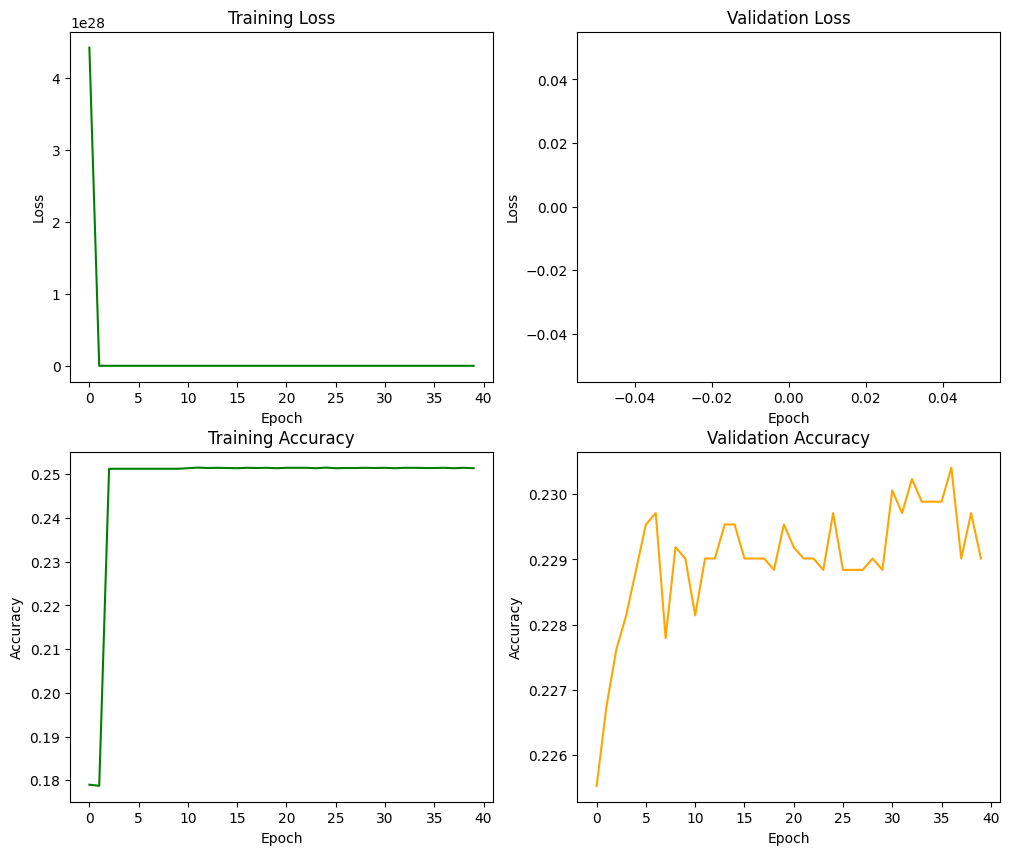

In [100]:
# visualize result

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color = 'green')
ax[0, 0].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color = 'orange')
ax[0, 1].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color = 'green')
ax[1, 0].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color = 'orange')
ax[1, 1].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [101]:
# evaluate model

test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.22847589857899137
